# FusionDB reactor browser

Lists all reactors side by side (one column per reactor) with every available field, including derived values. Columns with warnings are highlighted in yellow; mismatches beyond the 1% tolerance are highlighted in red (red overrides yellow). Warning messages are echoed below the table.
from fusdb.reactors_class import relations_for  # dynamic relation access


In [1]:
from pathlib import Path
import numbers
import re
import time
import warnings
import cProfile
import pstats
import sys

def find_repo_root(start: Path) -> Path:
    for path in (start, *start.parents):
        if (path / 'reactors').is_dir() and (path / 'src' / 'fusdb').is_dir():
            return path
    return start

root = find_repo_root(Path.cwd())
src_path = str(root / 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import pandas as pd
import yaml
import sympy as sp
from fusdb.loader import (
    OPTIONAL_METADATA_FIELDS,
    REQUIRED_FIELDS,
    find_reactor_dirs,
    load_reactor_yaml,
)
from fusdb.reactor_util import variable_aliases
from fusdb.relation_util import REL_TOL_DEFAULT

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Alias mapping for variable names
aliases = variable_aliases()

# Reserved keys (metadata fields) that should not be treated as parameters
reserved_keys = set(REQUIRED_FIELDS + OPTIONAL_METADATA_FIELDS + ["parameters", "root_dir"])

# Logging helper
PROFILE_TOP = 10
profiler = cProfile.Profile()
def log(msg: str) -> None:
    print(msg)

# Numeric value extraction
def numeric_value(value: object) -> float | None:
    if isinstance(value, sp.Expr):
        if not value.free_symbols:
            try:
                return float(value.evalf(chop=True))
            except (TypeError, ValueError):
                return None
    if isinstance(value, numbers.Real) and not isinstance(value, bool):
        return float(value)
    return None

def to_display_value(value: object) -> object:
    if isinstance(value, sp.Expr):
        if not value.free_symbols:
            evaluated = value.evalf(chop=True)
            try:
                return float(evaluated)
            except (TypeError, ValueError):
                pass
    return value

def format_sci(value: object) -> str:
    if isinstance(value, numbers.Real) and not isinstance(value, bool):
        if value != 0 and (abs(value) >= 1e3 or abs(value) <= 1e-3):
            return f"{value:.2e}"
    if value is None:
        return ""
    return str(value)

def classify_input_status(input_val: object, solved_val: object, tol: float) -> str:
    """Classify consistency between input and solved values."""
    input_num = numeric_value(input_val)
    solved_num = numeric_value(solved_val)
    if input_num is None or solved_num is None:
        return "none"
    delta = solved_num - input_num
    if delta == 0:
        return "green"
    scale = max(abs(input_num), abs(solved_num), 1.0)
    if abs(delta) <= tol * scale:
        return "yellow"
    return "red"

# Containers for tracking state
reactors: dict[str, object] = {}
explicit_params_by_reactor: dict[str, set[str]] = {}
warning_messages: dict[str, list[str]] = {}
computed_flags: dict[tuple[str, str], bool] = {}  # (param, reactor_id) -> is_computed
input_status: dict[tuple[str, str], str] = {}  # (param, reactor_id) -> status
red_reason: dict[tuple[str, str], str] = {}  # (param, reactor_id) -> reason (constraint/conflict/inconsistent)

profiler.enable()
log(f"Loading reactors from {root.resolve()}")

for reactor_dir in find_reactor_dirs(root):
    path = reactor_dir / 'reactor.yaml'
    log(f"Loading {reactor_dir.name}...")
    
    start = time.perf_counter()
    
    # Load reactor (this runs the solver and populates parameter_records)
    with warnings.catch_warnings(record=True) as caught:
        warnings.simplefilter('always')
        reactor = load_reactor_yaml(path)
    load_elapsed = time.perf_counter() - start
    log(f"  Loaded reactor in {load_elapsed:.2f}s; {len(caught)} warnings")
    
    reactors[reactor.id] = reactor
    
    # Use reactor.explicit_parameters (authoritative source from loader)
    explicit_params = reactor.explicit_parameters or set()
    log(f"  Explicit params: {len(explicit_params)}")
    
    if reactor.relations_used:
        log("  Relations used:")
        for tags, rel in reactor.relations_used:
            tag_label = ", ".join(tags) if tags else "untagged"
            output_name = rel.variables[0] if rel.variables else "?"
            log(f"    - {rel.name} ({output_name}) [{tag_label}]")
    
    explicit_params_by_reactor[reactor.id] = explicit_params
    
    # Mark computed vs explicit flags
    for key in reactor.parameters:
        computed_flags[(key, reactor.id)] = key not in explicit_params
    
    # Store warning messages for display
    messages = [str(w.message) for w in caught]
    warning_messages[reactor.id] = messages
    
    # Use parameter_records to determine status (replaces regex parsing)
    # This is much simpler and more reliable than parsing warning text
    for name, rec in reactor.parameter_records.items():
        if name in explicit_params:
            status = rec.get("status", "consistent")
            if status in ("constraint", "conflict", "inconsistent"):
                input_status[(name, reactor.id)] = "red"
                red_reason[(name, reactor.id)] = status

profiler.disable()
pstats.Stats(profiler).sort_stats("cumtime").print_stats(PROFILE_TOP)

# Build table
metadata_fields = REQUIRED_FIELDS + OPTIONAL_METADATA_FIELDS
parameter_names = sorted(
    {key for reactor in reactors.values() for key in reactor.parameters.keys()},
    key=lambda name: (name.lower(), name)
)
field_names = metadata_fields + parameter_names
log(f"Building table: {len(metadata_fields)} metadata fields, {len(parameter_names)} parameters")

parameter_set = set(parameter_names)
table_data: dict[str, list[object]] = {}

for rid, reactor in sorted(reactors.items()):
    values: list[object] = []
    explicit_params = explicit_params_by_reactor.get(rid, set())
    
    for name in field_names:
        if name in parameter_set:
            solved_val = to_display_value(reactor.parameters.get(name))
            
            if name in explicit_params:
                input_val = to_display_value(reactor.input_parameters.get(name))
                tol = reactor.parameter_tolerances.get(name, REL_TOL_DEFAULT)
                
                # Get status from parameter_records (or compute from values)
                rec = reactor.parameter_records.get(name, {})
                rec_status = rec.get("status", "consistent")
                
                if rec_status in ("constraint", "conflict", "inconsistent"):
                    status = "red"
                    input_status[(name, rid)] = status
                    red_reason[(name, rid)] = rec_status
                else:
                    # Normal comparison for parameters not flagged by solver
                    status = classify_input_status(input_val, solved_val, tol)
                    if status == "red":
                        red_reason[(name, rid)] = "inconsistent"
                    input_status[(name, rid)] = status
                
                input_str = format_sci(input_val)
                if status == "red":
                    reason = red_reason.get((name, rid))
                    limit = rec.get("constraint_limit")
                    computed = rec.get("computed_value")  # For conflicts: what the relation would compute
                    
                    if reason == "constraint" and limit is not None:
                        # Show constraint expression: input (<limit) or (>limit)
                        limit_str = format_sci(limit)
                        op = "<" if numeric_value(input_val) > limit else ">"
                        values.append(f"{input_str} ({op}{limit_str})")
                    elif reason == "conflict":
                        # Show conflict: input (calculated_value) or (conflict) if no different value
                        if computed is not None and computed != numeric_value(input_val):
                            values.append(f"{input_str} ({format_sci(computed)})")
                        else:
                            values.append(f"{input_str} (conflict)")
                    else:
                        # Inconsistent: show computed value
                        solved_str = format_sci(solved_val)
                        values.append(f"{input_str} ({solved_str})" if solved_str and solved_str != input_str else f"{input_str} (inconsistent)")
                else:
                    values.append(input_str)
            else:
                values.append(format_sci(solved_val))
        else:
            values.append(format_sci(to_display_value(getattr(reactor, name, None))))
    
    table_data[rid] = values

df = pd.DataFrame(table_data, index=field_names)

def style_cells(data: pd.DataFrame) -> pd.DataFrame:
    """Apply color styles based on input_status."""
    styles = pd.DataFrame('', index=data.index, columns=data.columns)
    for field in styles.index:
        for rid in styles.columns:
            parts = []
            if computed_flags.get((field, rid)):
                parts.append('text-decoration: underline;')
            status = input_status.get((field, rid))
            if status == 'red':
                parts.append('color: #b30000; font-weight: 600;')
            elif status == 'yellow':
                parts.append('color: #b58900;')
            elif status == 'green':
                parts.append('color: #0a7d2a;')
            styles.loc[field, rid] = ' '.join(parts)
    return styles

styled = df.style.apply(style_cells, axis=None)
styled = styled.format(escape=None)
display(styled)

# Show warnings below the table
for rid, msgs in warning_messages.items():
    if not msgs:
        continue
    print(f'Warnings for {rid}:')
    for msg in msgs:
        print(f' - {msg}')

Loading reactors from /home/alessmor/Scrivania/fusdb
Loading ARC_2015...
  Loaded reactor in 1.45s; 2 warnings
  Explicit params: 35
  Relations used:
    - tau_E_hubbard_nominal (tau_E) [confinement, tokamak, I-mode]
    - Thermal stored energy (W_th) [plasma]
    - Energy confinement time (tau_E) [plasma]
    - Major radius (R) [geometry]
    - Aspect ratio (A) [geometry]
    - Elongation (kappa) [geometry]
    - Elongation 95% (kappa) [geometry, tokamak]
    - Triangularity 95% (delta) [geometry, tokamak]
    - IPB elongation from volume (kappa_ipb) [geometry]
    - Tokamak volume (V_p) [geometry, tokamak]
    - Tokamak surface (S_p) [geometry, tokamak]
    - Troyon beta limit (beta_limit) [plasma, tokamak]
    - Greenwald density limit (n_GW) [plasma, tokamak]
    - Greenwald density fraction (f_GW) [plasma, tokamak]
    - Electron density from volume-averaged density (n_e) [plasma]
    - Electron density from ion fractions (n_e) [plasma]
    - Deuterium density from fraction (n_D)

,ARC_2015,DEMO_2018,EXAMPLE,Hammir2024,InfinityTwo2025,STEP2024EBCC,Stellaris2025
id,ARC_2015,DEMO_2018,EXAMPLE,Hammir2024,InfinityTwo2025,STEP2024EBCC,Stellaris2025
name,ARC 2015,EU-DEMO 2018,Example Reactor,Hammir 2024,INFINITY TWO 2025,STEP 2024 EB-CC,Stellaris 2025 - Point A
reactor_configuration,compact tokamak,tokamak,tokamak,spherical tokamak,stellarator,spherical tokamak,stellarator
organization,MIT,EUROFUSION,Example Organization,Realta,TypeOne Energy,UKAEA,Proxima
reactor_family,ARC,DEMO,,,,STEP,
country,USA,EUU,,,,GBR,
site,,,,,,,
design_year,2.02e+03,2.02e+03,,2.02e+03,2.02e+03,2.02e+03,2.02e+03
doi,10.1016/j.fusengdes.2015.07.008,10.1016/j.fusengdes.2022.113080,,10.1088/1741-4326/ad3fcb,10.1017/S0022377825000364,10.1088/1741-4326/ad6ea2,10.1016/j.fusengdes.2025.114868
notes,Conceptual compact tokamak from MIT.,EU-DEMO Physics Baseline 2018,,,,Refers to EC+EBW heating scenario with Conservative Confinement conditions,


Warnings for ARC_2015:
 - ARC_2015: ion fractions not provided; assuming 50-50 D-T.
 - Inputs P_fus=5.250e+08, T_avg=1.400e+01, V_p=1.530e+02, n_avg=1.300e+20 are inconsistent
Warnings for DEMO_2018:
 - Greenwald density fraction: cannot solve for f_GW = 1.2 from inputs (n_GW=6.718e+19, n_avg=8.062e+19) (violates constraints: f_GW <= 1)
 - Inputs I_p=1.775e+07, P_fus=2.000e+09, R=9.000e+00, T_avg=1.249e+01 are inconsistent
Warnings for Hammir2024:
 - Hammir2024: ion fractions not provided; assuming 50-50 D-T.
Warnings for InfinityTwo2025:
 - InfinityTwo2025: ion fractions not provided; assuming 50-50 D-T.
Warnings for Stellaris2025:
 - Stellaris2025: ion fractions not provided; assuming 50-50 D-T.
 - Explicit P_fus overridden: explicit=2700000000.0, solved=5265861974.3541
Warnings for STEP2024EBCC:
 - STEP2024EBCC: ion fractions not provided; assuming 50-50 D-T.
 - Inputs kappa=3.000e+00, kappa_95=2.800e+00 are inconsistent
 - Inputs A=1.800e+00, kappa=3.000e+00 are inconsistent
Warnin

In [3]:
ARC = load_reactor_yaml('/home/alessmor/Scrivania/fusdb/reactors/ARC_2015/reactor.yaml')
DEMO = load_reactor_yaml('/home/alessmor/Scrivania/fusdb/reactors/DEMO_2018/reactor.yaml')
STEP = load_reactor_yaml('/home/alessmor/Scrivania/fusdb/reactors/STEP_2024/reactor.yaml')
Stellaris = load_reactor_yaml('/home/alessmor/Scrivania/fusdb/reactors/STELLARIS/reactor.yaml')

/home/alessmor/Scrivania/fusdb/src/fusdb/registry/reactor_defaults.py:57: UserWarning: ARC_2015: ion fractions not provided; assuming 50-50 D-T.
  warn_func(f"{reactor_id}: ion fractions not provided; assuming 50-50 D-T.", UserWarning)
/home/alessmor/Scrivania/fusdb/src/fusdb/relation_class.py:298: UserWarning: Inputs P_fus=5.250e+08, T_avg=1.400e+01, V_p=1.530e+02, n_avg=1.300e+20 are inconsistent
  self._warn(det, UserWarning)
/home/alessmor/Scrivania/fusdb/src/fusdb/relation_class.py:497: UserWarning: Greenwald density fraction: cannot solve for f_GW = 1.2 from inputs (n_GW=6.718e+19, n_avg=8.062e+19) (violates constraints: f_GW <= 1)
  self._warn(msg, UserWarning)
/home/alessmor/Scrivania/fusdb/src/fusdb/relation_class.py:298: UserWarning: Inputs I_p=1.775e+07, P_fus=2.000e+09, R=9.000e+00, T_avg=1.249e+01 are inconsistent
  self._warn(det, UserWarning)
/home/alessmor/Scrivania/fusdb/src/fusdb/registry/reactor_defaults.py:57: UserWarning: STEP2024EBCC: ion fractions not provided; a

In [4]:
# print Vplasma, Tavg, navg, tauE, fusion power and auxiliary power for the reactors
for reactor in [ARC, DEMO, STEP, Stellaris]:
    Vplasma = reactor.parameters.get('V_p')
    Tavg = reactor.parameters.get('T_avg')
    navg = reactor.parameters.get('n_avg')
    tauE = reactor.parameters.get('tau_E')
    P_fusion = reactor.parameters.get('P_fus')
    P_aux = reactor.parameters.get('P_aux')
    print(f"{reactor.id}: V_plasma={format_sci(Vplasma)}, T_avg={format_sci(Tavg)}, n_avg={format_sci(navg)}, tau_E={format_sci(tauE)}, P_fusion={format_sci(P_fusion)}, P_auxiliary={format_sci(P_aux)}")

ARC_2015: V_plasma=153.0, T_avg=14.0, n_avg=1.30e+20, tau_E=0.64, P_fusion=5.25e+08, P_auxiliary=
DEMO_2018: V_plasma=2.57e+03, T_avg=12.49, n_avg=8.06e+19, tau_E=1.90816809994225, P_fusion=2.00e+09, P_auxiliary=
STEP2024EBCC: V_plasma=788.9464369689387, T_avg=9.69, n_avg=1.64e+20, tau_E=1.0293534261766426, P_fusion=1.56e+09, P_auxiliary=1.30e+08
Stellaris2025: V_plasma=425.0, T_avg=12.0, n_avg=3.17e+20, tau_E=1.46, P_fusion=5.27e+09, P_auxiliary=5.00e+07


Skipping Hammir2024: Sauter cross-section requires numeric R and a
Skipping InfinityTwo2025: Cross-section not implemented for 'stellarator'
Skipping Stellaris2025: Cross-section not implemented for 'stellarator'


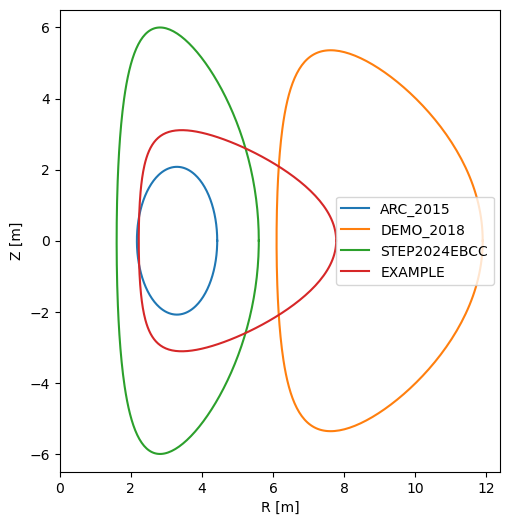

In [5]:
# plot plasma cross-sections (Sauter geometry)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 6))
max_outer = 0.0
max_z = 0.0

for reactor in reactors.values():
    try:
        reactor.plot_cross_section(ax=ax, label=reactor.id)
        line = ax.lines[-1]
        r_vals = line.get_xdata()
        z_vals = line.get_ydata()
    except (ValueError, NotImplementedError) as exc:
        print(f"Skipping {reactor.id}: {exc}")
        continue
    try:
        outer = float(reactor.R) + float(reactor.a)
    except (TypeError, ValueError, AttributeError):
        outer = max(r_vals)
    max_outer = max(max_outer, outer)
    max_z = max(max_z, max(abs(z) for z in z_vals))

ax.set_aspect('equal', adjustable='box')
ax.set_xlim(0, max_outer+0.5)
ax.set_ylim(-max_z-0.5, max_z+0.5)
ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.legend()
plt.show()
